In [1]:
import os
import sys
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import tensorflow as tf
from keras import Model
from keras.layers import *
from matplotlib import style
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
num_cores = int(os.cpu_count() * 0.8)
tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)
print(f"Python: {sys.version}")

Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [3]:
style.use('fivethirtyeight')

def print_free_memory(end="\r"):
    print(f"Free memory: {psutil.virtual_memory().free / 1024 / 1024 / 1024} GB", end=end)

print_free_memory()

In [4]:
data_path = "dataset/"
info = pd.read_csv(data_path + 'labels.csv')
# info = info[:50]
info.head()

,filename,class,sex,xcenter,ycenter,w,h
0,annaifert\0000.jpg,face,none,0.385185,0.465027,0.087037,0.081476
1,annaifert\0000.jpg,face,none,0.554167,0.158340,0.110185,0.092237
2,annaifert\0001.jpg,face,female,0.368056,0.152963,0.104630,0.119259
3,annaifert\0002.jpg,face,female,0.500463,0.296296,0.326852,0.398519
4,annaifert\0003.jpg,face,none,0.454167,0.225405,0.047222,0.112080


In [5]:
import random


def print_process(index, count, interval, label, start_time):
    if index % interval == 0 and index != 0:
        remaining_time = (time.time() - start_time) / index * (count - index)
        print(f"{label}: {index} / {count} ({index / count * 100:.2f}%), remaining time: {int(remaining_time / 60)}:{int(remaining_time % 60)}", end="\r")

def crop_and_save(left, right, top, bottom, image, save_path, shift=0) -> np.ndarray:
    if shift > 0:
        max_shift = int(shift * min(right - left, bottom - top))
        if max_shift > 0:
            shift = np.random.randint(0, max_shift)
        else:
            shift = 0
        # shift = np.random.randint(0, int(shift * min(right - left, bottom - top)))
        left += shift
        right -= shift
        top += shift
        bottom -= shift

    if left < 0:
        right -= left
        left = 0
    if top < 0:
        bottom -= top
        top = 0
    if right > image.shape[1]:
        left -= right - image.shape[1]
        right = image.shape[1]
    if bottom > image.shape[0]:
        top -= bottom - image.shape[0]
        bottom = image.shape[0]

    left, right, top, bottom = int(left), int(right), int(top), int(bottom)

    if left < 0 or top < 0 or right > image.shape[1] or bottom > image.shape[0]:
        return np.array([])

    crop_image = image[top:bottom, left:right]
    if crop_image.shape[0] > 0 and crop_image.shape[1] > 0:
        cv2.imwrite(save_path, np.array(crop_image))
    return crop_image

def prepare_data():
    question = input(
        "Previous data will be deleted!\n" +
        "Do you want to prepare data? (y/n): ")
    if question != "y":
        return

    folder = data_path + 'prepared'
    if not os.path.exists(folder):
        os.makedirs(folder)

    # image types "away_from_face", "face", "close_to_face", "no_face"

    face_folder = os.path.join(folder, 'face')
    away_folde = os.path.join(folder, 'away_from_face')
    close_folder = os.path.join(folder, 'close_to_face')
    no_face_folder = os.path.join(folder, 'no_face')
    all_paths = [face_folder, away_folde, close_folder, no_face_folder]

    # prepare folders
    for path in all_paths:
        if not os.path.exists(path):
            os.makedirs(path)
        for file in os.listdir(path):
            os.remove(os.path.join(path, file))

    start = time.time()
    for index, row in info.iterrows():
        image = cv2.imread(data_path + row['filename'])

        correction = 0.0
        xcenter = row['xcenter'] * image.shape[1]
        ycenter = row['ycenter'] * image.shape[0]
        box_width = row['w'] * image.shape[1] * (1 + correction)
        box_height = row['h'] * image.shape[0] * (1 + correction)

        long_side = max(box_width, box_height)
        short_side = min(box_width, box_height)
        box_left = int(xcenter - long_side / 2)
        box_right = int(xcenter + long_side / 2)
        box_top = int(ycenter - long_side / 2)
        box_bottom = int(ycenter + long_side / 2)

        # face
        save_path = os.path.join(face_folder, str(index).zfill(5)) + ".jpg"
        crop_and_save(box_left, box_right, box_top, box_bottom, image, save_path)

        # close to face
        for i in range(np.random.randint(2, 4)):
            size = int(np.random.randint(short_side * 0.25, short_side * 0.5))
            close_left = int(xcenter - box_width / 2 + np.random.randint(0, box_width - size))
            close_top = int(ycenter - box_height / 2 + np.random.randint(0, box_height - size))
            close_right = close_left + size
            close_bottom = close_top + size
            save_path = os.path.join(close_folder, str(index).zfill(5)) + "_" + str(i) + ".jpg"
            crop_and_save(close_left, close_right, close_top, close_bottom, image, save_path)

        if row["sex"] == "none":
            continue # mean on image can be more than one face

        # away from face
        for i in range(3):
            size = int(np.random.randint(short_side * 2, short_side * 5))
            try:
                away_left = int(np.random.randint(xcenter + box_width / 2 - size, xcenter - box_width / 2))
                away_top = int(np.random.randint(ycenter + box_height / 2 - size, ycenter - box_height / 2))
                away_right = away_left + size
                away_bottom = away_top + size
                save_path = os.path.join(away_folde, str(index).zfill(5)) + "_" + str(i) + ".jpg"
                crop_and_save(away_left, away_right, away_top, away_bottom, image, save_path)
            except:
                pass

        # no face
        size_coeffs = [0.5, 1, 2, 3, 4, 5]
        # select 4 random points
        size_coeffs = random.sample(size_coeffs, 3)
        for size_coef in size_coeffs:
            size = int(long_side * size_coef)
            coord_x, coord_y = np.meshgrid(range(image.shape[1] // size), range(image.shape[0] // size))
            valid_indices = np.logical_and(
                np.abs(xcenter - (coord_x + 0.5) * size) < box_width / 2 + size / 2,
                np.abs(ycenter - (coord_y + 0.5) * size) < box_height / 2 + size / 2)
            # select 5 random points
            all_indices = []
            for i in range(coord_x.shape[0]):
                for j in range(coord_x.shape[1]):
                    if not valid_indices[i, j]:
                        all_indices.append((j, i)) # x, y
            if len(all_indices) > 5:
                all_indices = random.sample(all_indices, 1)

            for i, j in all_indices:
                no_face_left = int(i * size)
                no_face_top = int(j * size)
                no_face_right = no_face_left + size
                no_face_bottom = no_face_top + size
                save_path = os.path.join(no_face_folder, str(index).zfill(5)) + "_" + str(i) + "_" + str(j) + str(size_coef) + ".jpg"
                crop_and_save(no_face_left, no_face_right, no_face_top, no_face_bottom, image, save_path)

        print_process(index, len(info), 10, "prepare_data", start)

prepare_data()

In [6]:
classes = ["away_from_face", "face", "close_to_face", "no_face"]
# classes = ["face", "no_face"]
all_images = []
all_labels = []

IMG_SIZE = 48
channels = 3

total_count = [os.listdir(os.path.join(data_path, "prepared", class_name)) for class_name in classes]
load_count = [0] * len(classes)

_start = time.time()
for i, class_name in enumerate(classes):
    folder = os.path.join(data_path, "prepared", class_name)
    print(f"loading {class_name}...")
    start = time.time()
    # for file in np.random.choice(os.listdir(folder), 100):
    for file in os.listdir(folder):
        image = cv2.imread(os.path.join(folder, file))
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # convert to numpy array
        image = np.array(image)
        all_images.append(image)
        all_labels.append(i)
        load_count[i] += 1
        print_process(load_count[i], len(total_count[i]), 10, "load_data", start)
    print(f"\nloaded {class_name}! {load_count[i]} images\n")

_end = time.time()
print(f"loaded {len(all_images)} images in {_end - _start} seconds")

loading away_from_face...
load_data: 5220 / 5225 (99.90%), remaining time: 0:0
loaded away_from_face! 5225 images

loading face...
load_data: 2490 / 2492 (99.92%), remaining time: 0:0
loaded face! 2492 images

loading close_to_face...
load_data: 6250 / 6253 (99.95%), remaining time: 0:0
loaded close_to_face! 6253 images

loading no_face...
load_data: 5320 / 5321 (99.98%), remaining time: 0:0
loaded no_face! 5321 images

loaded 19291 images in 36.16244173049927 seconds


In [7]:
print_free_memory()

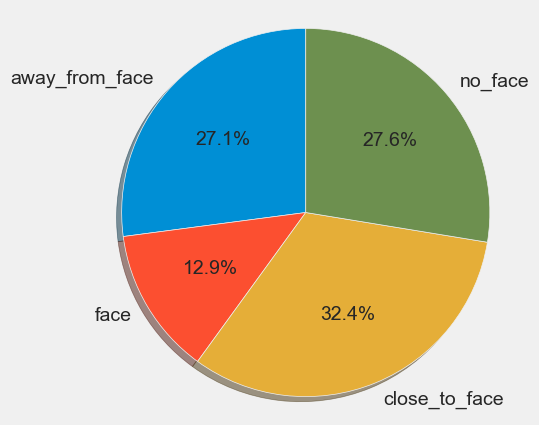

In [8]:
# plot proportion of classes
plt.figure(figsize=(5, 5))
plt.pie(load_count, labels=classes, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

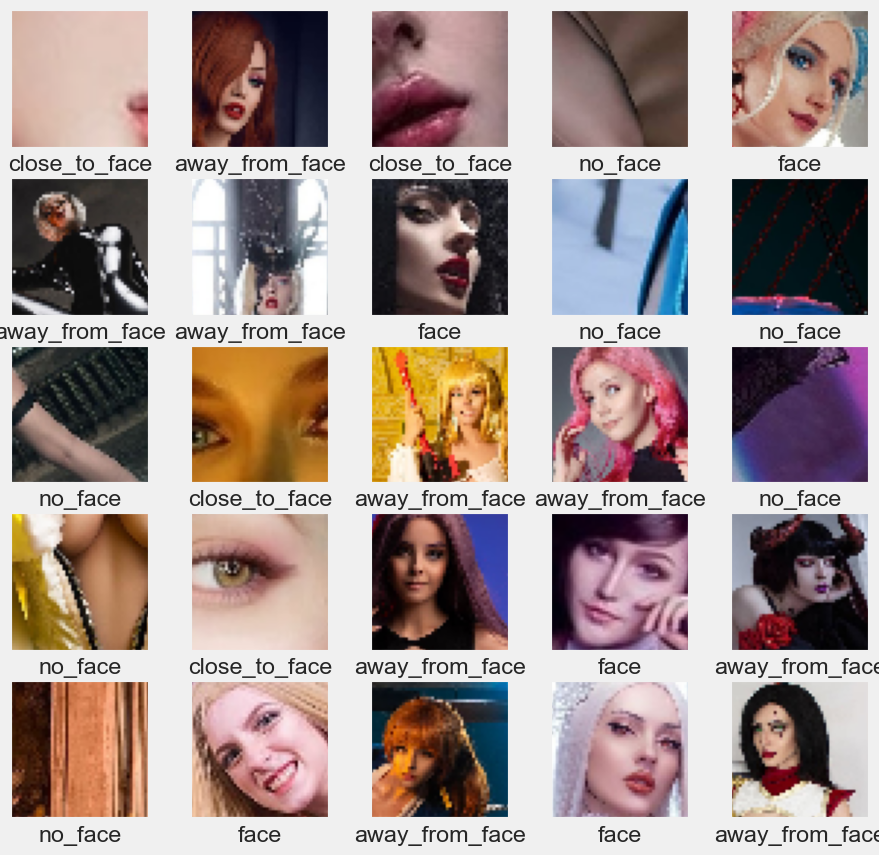

In [9]:
def plot_some_images(images, count):
    # plot random images
    plt.figure(figsize=(10, 10))
    for i in range(count):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        n = np.random.randint(0, len(images))
        plt.imshow(images[n])
        plt.xlabel(classes[all_labels[n]])
    plt.show()

plot_some_images(all_images, 25)

In [10]:
all_images = np.array(all_images)

def convert_images_to_float16(image_array, batch_size=100):
    num_images = len(image_array)
    float16_array = np.empty_like(image_array, dtype=np.float16)

    for i in range(0, num_images, batch_size):
        batch_start = i
        batch_end = min(i + batch_size, num_images)
        float_array = image_array[batch_start:batch_end] / 255.0
        float16_array[batch_start:batch_end] = float_array.astype(np.float16)
        print_free_memory()

    return float16_array

scaled_images = convert_images_to_float16(all_images)

scaled_images = np.array(scaled_images)
one_hot_labels = np.eye(len(classes))[all_labels]
one_hot_labels = np.argmax(one_hot_labels, axis=1)

# split data
x_train, x_test, y_train, y_test = train_test_split(
    scaled_images, one_hot_labels, test_size=1/10, random_state=42, stratify=one_hot_labels) # 1/10 of 100% = 10%
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=1/9, random_state=42, stratify=y_train) # 1/9 of 90% = 10%

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (15432, 48, 48, 3)
Shape of x_val: (1929, 48, 48, 3)
Shape of x_test: (1930, 48, 48, 3)


In [11]:
print_free_memory()

In [19]:
def conv_block(input, fcount, fsize, padding, batch_norm=True, pool_size=(3, 3)):
    x = input
    for i in range(len(fcount)):
        x = Conv2D(fcount[i], fsize[i], padding=padding)(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    # x = AveragePooling2D(pool_size=pool_size)(x)
    return x

def skip_conv_block(input, fcount, fsize, padding, batch_norm=True, pool_size=(3, 3)):
    x = input
    for i in range(len(fcount)):
        x = Conv2D(fcount[i], fsize[i], padding=padding)(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if i == 0:
            input = x
    x = add([input, x])
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

def paralle_conv_block(input, fcount, batch_norm=True, pool_size=(3, 3)):
    tower_1 = Conv2D(fcount[0], (1, 1), padding='same', activation='relu')(input)
    tower_1 = BatchNormalization()(tower_1)

    tower_2 = Conv2D(fcount[1], (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(fcount[2], (3, 3), padding='same', activation='relu')(tower_2)
    tower_2 = BatchNormalization()(tower_2)

    tower_3 = Conv2D(fcount[3], (1, 1), padding='same', activation='relu')(input)
    tower_3 = Conv2D(fcount[4], (5, 5), padding='same', activation='relu')(tower_3)
    tower_3 = BatchNormalization()(tower_3)

    tower_4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    tower_4 = Conv2D(fcount[5], (1, 1), padding='same', activation='relu')(tower_4)

    output = concatenate([tower_1, tower_2, tower_3, tower_4], axis=3)
    output = MaxPooling2D(pool_size=pool_size)(output)
    return output


_input = Input(shape=(IMG_SIZE, IMG_SIZE, channels))

# Create the convolutional base
_conv1 = conv_block(_input, [32]*2, [(3, 3)]*2, 'same', pool_size=(2, 2))
_conv2 = conv_block(_conv1, [64]*3, [(3, 3)]*3, 'same', pool_size=(2, 2))
_conv3 = conv_block(_conv2, [128]*3, [(3, 3)]*3, 'same', pool_size=(2, 2))
_conv4 = conv_block(_conv3, [256]*3, [(3, 3)]*3, 'same', pool_size=(2, 2))

# _flat = Flatten()(_conv4)
_global_pool = GlobalAveragePooling2D()(_conv4)
_last = _global_pool
for i in range(2):
    _dense = Dense(256 / (2 ** i))(_last)
    _dropout = Dropout(0.35)(_dense)
    _batch_norm = BatchNormalization()(_dropout)
    _activation = Activation('relu')(_batch_norm)
    _last = _activation

# Output layer
_output = Dense(len(classes), activation='softmax')(_last)
model = Model(inputs=_input, outputs=_output)

model_config = model.get_config()
model = keras.models.Sequential.from_config(model_config)

# plot model
model.summary()
# keras2ascii(model)
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_52 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 activation_52 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_53 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 activation_53 (Activation)  (None, 48, 48, 32)        0   

In [20]:
parameters_count = model.count_params()

def prettify_number(number):
    # let 1024 -> 1K, 27805 -> 27.8K, 1234567 -> 1.2M
    if number < 1000:
        return str(number)
    elif number < 1000000:
        return f"{number / 1000:.1f}K"
    else:
        return f"{number / 1000000:.1f}M"

def lr_scheduler(epoch, lr):
    if epoch % 4 == 3:
        return lr * 0.5
    else:
        return lr

model_name = f"model_s{IMG_SIZE}_p{prettify_number(parameters_count)}"
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
epochs = 10

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = os.path.join(data_path, 'checkpoints', model_name, 'cp-{epoch:04d}.ckpt')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# print some info
print(f"Model name: {model_name}")
print(f"Parameters count: {prettify_number(parameters_count)}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Checkpoint path: {checkpoint_path}")
print(f"Tensorboard path: {os.path.join(data_path, 'logs', model_name)}")
print(f"LR callback: {learning_rate}")

Model name: model_s48_p2.1M
Parameters count: 2.1M
Learning rate: <keras.callbacks.LearningRateScheduler object at 0x000001ABC7F6A2F0>
Epochs: 10
Checkpoint path: dataset/checkpoints\model_s48_p2.1M\cp-{epoch:04d}.ckpt
Tensorboard path: dataset/logs\model_s48_p2.1M
LR callback: <keras.callbacks.LearningRateScheduler object at 0x000001ABC7F6A2F0>


In [28]:
# load latest checkpoint
if input("Load latest checkpoint? [y/n] ") == 'y':
    latest = tf.train.latest_checkpoint(os.path.join(data_path, 'checkpoints', model_name))
    if latest:
        print(f"Loading latest checkpoint: {latest}")
        model.load_weights( latest)
    else:
        print("No checkpoint found")
else:
    print("skipping loading checkpoint")

Loading latest checkpoint: dataset/checkpoints\model_s48_p2.1M\cp-0004.ckpt


In [22]:
# aug = ImageDataGenerator(
#     rotation_range=30,
#     shear_range=0.1,
#     horizontal_flip=True,
#     fill_mode="nearest")

if input("Train model? [y/n] ") == 'y':
    _start = time.time()
    history = model.fit(
        x_train, y_train,
        # steps_per_epoch=len(x_train) // 32,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, learning_rate],
    )
    _end = time.time()
    print(f"trained {model_name} in {_end - _start} seconds")
else:
    print("skipping training")

Epoch 1/10
483/483 [==============================] - ETA: 0s - loss: 0.7662 - accuracy: 0.6983
Epoch 1: val_accuracy improved from -inf to 0.72576, saving model to dataset/checkpoints\model_s48_p2.1M\cp-0001.ckpt
483/483 [==============================] - 125s 253ms/step - loss: 0.7662 - accuracy: 0.6983 - val_loss: 0.7725 - val_accuracy: 0.7258 - lr: 0.0010
Epoch 2/10
483/483 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8356
Epoch 2: val_accuracy improved from 0.72576 to 0.82530, saving model to dataset/checkpoints\model_s48_p2.1M\cp-0002.ckpt
483/483 [==============================] - 118s 244ms/step - loss: 0.4355 - accuracy: 0.8356 - val_loss: 0.4420 - val_accuracy: 0.8253 - lr: 9.5000e-04
Epoch 3/10
483/483 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8756
Epoch 3: val_accuracy improved from 0.82530 to 0.85640, saving model to dataset/checkpoints\model_s48_p2.1M\cp-0003.ckpt
483/483 [==============================] - 116s 240m

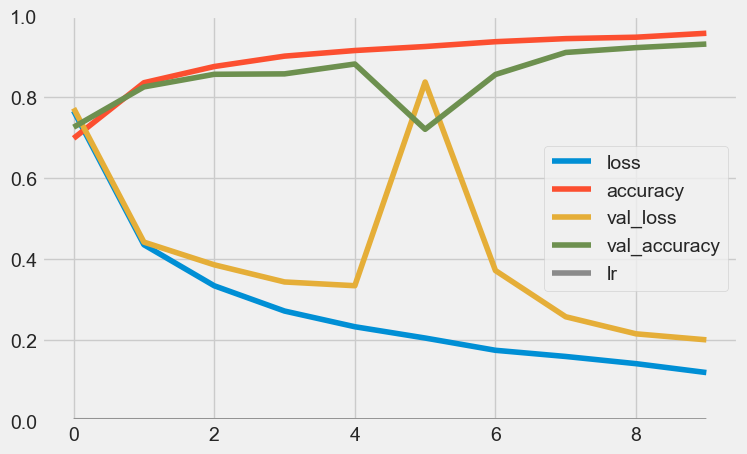

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [24]:
# aug = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     horizontal_flip=True,
#     fill_mode="nearest")

learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 6.3025e-04 * 0.95 ** x)
epochs = 10

history = model.fit(
    x_train, y_train,
    # steps_per_epoch=len(x_train) // 32,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback, learning_rate],
)

Epoch 1/10
483/483 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9585
Epoch 1: val_accuracy did not improve from 0.93105
483/483 [==============================] - 119s 246ms/step - loss: 0.1159 - accuracy: 0.9585 - val_loss: 0.3592 - val_accuracy: 0.8891 - lr: 6.3025e-04
Epoch 2/10
483/483 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9622
Epoch 2: val_accuracy did not improve from 0.93105
483/483 [==============================] - 112s 232ms/step - loss: 0.1055 - accuracy: 0.9622 - val_loss: 0.2868 - val_accuracy: 0.9253 - lr: 5.9874e-04
Epoch 3/10
483/483 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9669
Epoch 3: val_accuracy improved from 0.93105 to 0.93209, saving model to dataset/checkpoints\model_s48_p2.1M\cp-0003.ckpt
483/483 [==============================] - 113s 233ms/step - loss: 0.0920 - accuracy: 0.9669 - val_loss: 0.1992 - val_accuracy: 0.9321 - lr: 5.6880e-04
Epoch 4/10
483/483 [=============

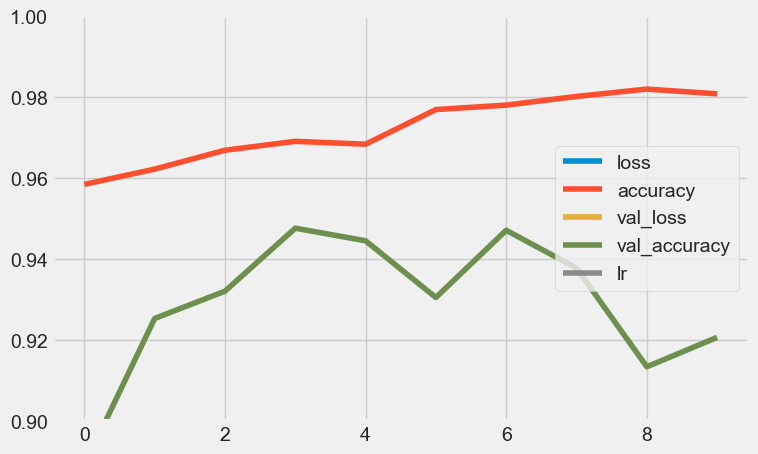

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.9, 1)
plt.show()

In [26]:
model.save(os.path.join(data_path, "models", model_name, "model.h5"))

In [49]:
# model_name = "model_s48_p2.1M"
model_name = "model2_s48_p1.2M"
model = keras.models.load_model(f"{data_path}/models/{model_name}/model.h5")

In [50]:
for layer in model.layers:
    if 'conv' in layer.name:
        print(f"{layer.name} {layer.output.shape}, filters: {layer.filters}, kernel_size: {layer.kernel_size}, strides: {layer.strides}, padding: {layer.padding}")
    if 'dropout' in layer.name:
        print(f"{layer.name} {layer.output.shape}, rate: {layer.rate}")
print(f"Parameters count: {model.count_params()}")

conv2d (None, 48, 48, 32), filters: 32, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_1 (None, 48, 48, 32), filters: 32, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_2 (None, 24, 24, 64), filters: 64, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_3 (None, 24, 24, 64), filters: 64, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_4 (None, 24, 24, 64), filters: 64, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_5 (None, 12, 12, 128), filters: 128, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_6 (None, 12, 12, 128), filters: 128, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_7 (None, 12, 12, 128), filters: 128, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_8 (None, 6, 6, 128), filters: 128, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_9 (None, 6, 6, 128), filters: 128, kernel_size: (3, 3), strides: (1, 1), padding: same
conv2d_10 (None, 6, 6, 128), filters: 128, kernel_size: 

In [51]:
model.evaluate(x_test, y_test)

61/61 [==============================] - 3s 43ms/step - loss: 0.1675 - accuracy: 0.9648


[0.1675090193748474, 0.9647668600082397]

61/61 [==============================] - 3s 42ms/step


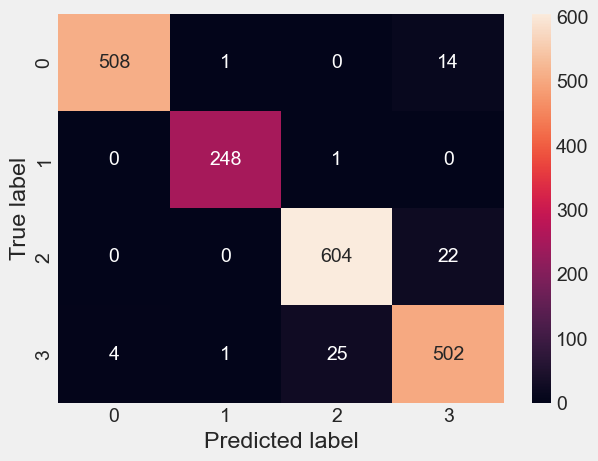

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=classes))

                precision    recall  f1-score   support

away_from_face       0.99      0.97      0.98       523
          face       0.99      1.00      0.99       249
 close_to_face       0.96      0.96      0.96       626
       no_face       0.93      0.94      0.94       532

      accuracy                           0.96      1930
     macro avg       0.97      0.97      0.97      1930
  weighted avg       0.97      0.96      0.96      1930



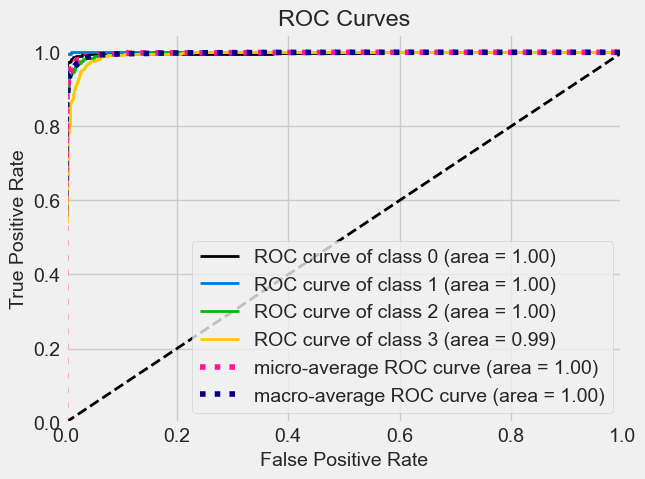

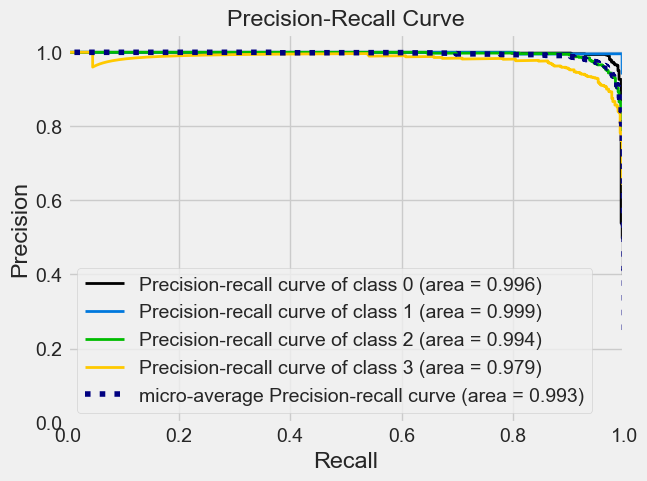

In [54]:
import scikitplot as skplt


skplt.metrics.plot_roc(y_true, y_pred)
# plt.xscale('log')
plt.show()
skplt.metrics.plot_precision_recall(y_true, y_pred)
# plt.yscale('log')
plt.show()

In [55]:
# evaluate average confidence of correct predictions
class_pred_count = np.zeros(len(classes))
class_pred_sum = np.zeros(len(classes))
for i in range(len(y_pred)):
    for j in range(len(classes)):
        if y_pred_classes[i] == j and y_true[i] == j:
            class_pred_count[j] += 1
            class_pred_sum[j] += y_pred[i][j]

class_pred_avg = class_pred_sum / class_pred_count

for i in range(len(classes)):
    print(f"{classes[i]}: {class_pred_avg[i]}")

away_from_face: 0.9974754388172795
face: 0.9998969885130082
close_to_face: 0.9935652290945811
no_face: 0.9928845702651963


In [56]:
# print accuracy_score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred_classes))

0.9647668393782384


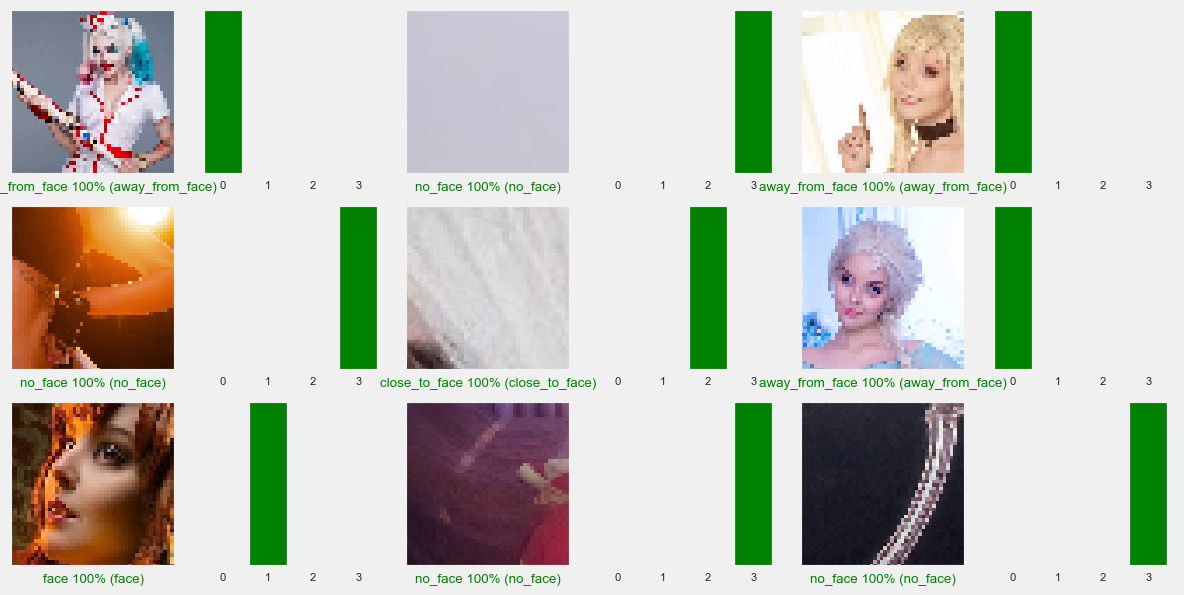

In [57]:
# plot some images with predictions

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i].reshape(IMG_SIZE, IMG_SIZE, 3)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # convert image back to float64
    img = img.astype(np.float64)
    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel(f"{classes[predicted_label]} {100 * np.max(predictions_array):2.0f}% ({classes[true_label]})", color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(len(classes)))
    plt.yticks([])
    thisplot = plt.bar(range(len(classes)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

num_rows = 3
num_cols = 3
num_images = num_rows * num_cols
#set font size
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    n = np.random.randint(0, len(y_pred))
    # while y_pred_classes[n] == y_true[n]:
    #     n = np.random.randint(0, len(y_pred))
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(n, y_pred[n], y_true, x_test)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(n, y_pred[n], y_true)
plt.tight_layout()
# plt.savefig(os.path.join(data_path, "models", model_name, "predictions.png"))
plt.show()

In [42]:
def get_images(count, _class):
    path = "dataset/prepared/" + _class
    images = []
    files = os.listdir(path)
    samples = np.random.choice(files, count)
    for i in samples:
        image = cv2.imread(os.path.join(path, i))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype(np.float64)
        image /= 255.0
        images.append(image)
    return np.array(images)

In [43]:
def plot_feature_map(img, model, layer_name, file_name, plot=True):
    # create new model with layer_name as output
    new_model = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)
    features = new_model.predict(img, verbose=0)
    features = tf.reshape(features, shape=(16, 16))
    label = np.argmax(model.predict(img, verbose=0))

    plt.figure(figsize=(7.5, 4))
    plt.subplot(121)
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(f"{classes[label]}")
    plt.subplot(122)
    plt.imshow(features)
    plt.axis('off')
    plt.title("Feature Map")
    plt.tight_layout()
    plt.savefig(os.path.join(data_path, "models", model_name, file_name))
    if plot:
        plt.show()
    plt.close()

In [47]:
# find globa average pooling layer
gap_layer = None
for layer in model.layers:
    if 'global_average_pooling2d' in layer.name:
        gap_layer = layer.name
        print(gap_layer)
        break

if gap_layer is None:
    Exception("Global Average Pooling Layer not found")

count = 3
plt.rcParams.update({'font.size': 14})
# decrease space between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)
face_images = []
for _class in classes:
    face_images.append(get_images(count, _class))
face_images = np.array(face_images).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
for i in range(len(face_images)):
    plot_feature_map(face_images[i:i+1], model, gap_layer, f"gap_{i}.png", plot=False)
    print(f"Saved feature map {i}", end="\r")

global_average_pooling2d_3


<Figure size 640x480 with 0 Axes>

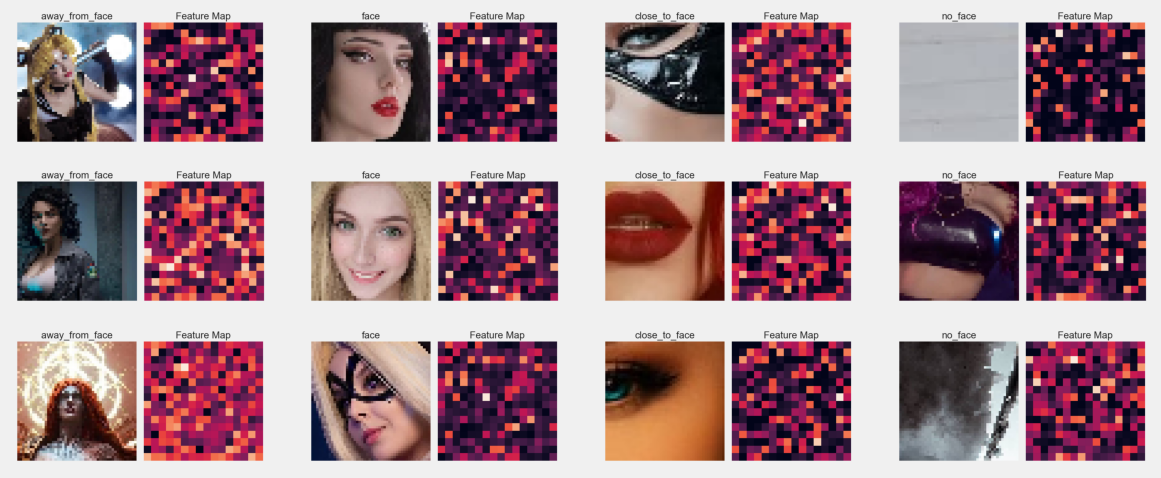

In [48]:
# load saved feature maps and plot
feature_maps = []
for i in range(12):
    img = cv2.imread(os.path.join(data_path, "models", model_name, f"gap_{i}.png"))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    feature_maps.append(img)

feature_maps = np.array(feature_maps)
# plot them on a grid
# increase font size
plt.figure(figsize=(12, 5))
for i in range(12):
    plt.subplot(3, 4, i % 3 * 4 + i // 3 + 1)
    plt.imshow(feature_maps[i])
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(data_path, "models", model_name, "gap.png"))
plt.show()

In [ ]:
face_images = get_images(25)

target_layers = []
model = keras.models.load_model("dataset/models/model2_s48_p1.2M/model.h5")
original_model = model
for i, layer in enumerate(model.layers):
    # if 'conv' not in layer.name:
    #     continue
    print(f"{i} {layer.name} {layer.output.shape}")
    target_layers.append(i)

print(target_layers)
# target_layers = target_layers[:1]
for i in range(len(target_layers)):
    print(f"layer {target_layers[i]}")
    model = Model(inputs=original_model.inputs, outputs=original_model.layers[target_layers[i]].output)

    feature_maps = model.predict(face_images)
    width = int(feature_maps.shape[3] ** 0.5)
    height = int(feature_maps.shape[3] / width)
    ix = 1
    plt.figure(figsize=(10, 10))
    for j in range(25):
        ax = plt.subplot(5, 5, j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # map = feature_maps[j, :, :, :].sum(axis=2)
        map = feature_maps[0, :, :, j]
        plt.imshow(map, cmap='gray')
    # save plot to file
    plt.savefig(f"feature_maps_{target_layers[i]}.png")
    plt.show()